<center><h1> Lab05 102062207 Regressor</h1></center>



# General Description
This notebook will be divided into 3 parts, each part will be corresponded to one of the three question given in the this assigment, and each part will also be broke into several subsection in order to clarify my code and thoughts. 

Now, we will walk through the whole assignment in the following order:
* Implementation of LassoRegressor
* Tune & Train the LassoRegressor
* Feature Selection and XRegressor

# Part I. Implementation of LassoRegressor

The LassoRegressor is a type of regressor that deal with the regression problem by solving the cost function:
$$\arg\min_{\boldsymbol{w}\in\mathbb{R}^{D},b}\frac{1}{2N}\Vert\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}-b\boldsymbol{1})\Vert^{2}+\alpha\Vert\boldsymbol{w}\Vert_{1},$$
 
Where $\alpha$ is a constant that will determine how much the **1-norm** term will influence the cost function, and the term $N$ is the number of samples that used to train the regressor.

To lower the result of the cost function above, one frequently used method is **gradient descent**:
$$x^{(t+1)}=x^{(t)}-\eta g$$
Where t is the t-th iteration, $\eta$ is learning rate, or stepsize, and $g$ is the gradient. By solving this equation iteratively, we can reach a **local optimum point** with a proper **stepsize**.


Since we need to compute gradient, we have to apply **partial differentiation** to the cost function. However, one may found that is that the **1-norm** term might be **non-differentiable** at some points. This phenomenon will cause a big problem when we are training the regressor because that we want to use gradient descent method to train, but **we cannot obtain a gradient from a non-differentiable point.**

To cope with that annoying non-differentialble problem, I choose **subgradient method** as a method to tackle the problem.

### Subgradient Method
The idea of subgradient method is simple :
* When the point is differentialble, we just simply compute the gradient
* If it's not differentiable, we randomly assign a value $[-1, 1]$ to it, as a **subgradient** and use it to do the descent task.

However, a **negative subgradient may to point to a descent direction.** Some constraint have to be imposed on it to make sure that our algorithm will descent.

Thus, I impose the following constraint to the subgradient:
$$\eta=\frac{f(x_k) - f^{lev}_{k}}{\Vert s_k\Vert ^2}$$

Where $\eta$ is a **modified** learning rate, $s_k$ is a subgradient, $f(x_k)$ is the cost function at iteration $k$, and $f^{lev}_{k}=\min_{0\leq i\leq k}f(x_{i})$.

This constraint can be simply interpreted as the description below:
* If the regressor is converged to some point, the  $\eta$ will be closed or equal to $0$.
  - that is, when the regressor is closed to some local optimum points, it shouldn't take a big step size. This can prevent it from leaving the local optimum point since it has limited effect on the descent direction .
* If the regressor is far from some points with low cost, the $\eta$ will increase.
  - that is, since you are not closed to any local optimum, you can take a big step.
  
By applying this constraint, we can make sure that the non-differential point won't drag the descent direction away from local optimum point, and thus the whole process will descent.

In [1]:
%matplotlib inline

### Implementation

Now let's take a look at my implementation.
The comments in the code below will explain the details of my implementation.

In [2]:
from pylab import *
from copy import deepcopy

In [3]:
class LassoRegressor(object):
    
    def __init__(self, eta=0.001, alpha=0.001, n_iter=40, random_state=1, zero=1e-10):
        """ Initialize LassoRegressor.
        
        Parameters
        ----------
        eta : float
              Learing rate.
        alpha : float
              The coefficient of the 1-norm term in the cost function
        n_iter : int
              Number of iterations.
        random_state : int
              Random seed.
        zero : float
              Value that smaller than zero will be considered as zero.
        """
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.zero = zero
        self.random_state = random_state
        
    def fit(self, X, y, stop_crit=1e+15):
        """ Fit the model with given traning set.
        
        Parameters
        ----------
        X : ndarray
            Training data.
        y : ndarray
            Label of training data.
        stop_crit : float
            If the result of cost function exceeds this value,
            the training process will be stop since it cannot
            converge.
        
        Returns
        -------
        self :
               Trained model.
        """
        
        # First, we initialize the weights with random value.
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        N = X.shape[0]
        

        # After initializing the weights, we start iterating to
        # solve the cost function. The self.w_[0] indicates the
        # intercept/bias of the function, so we don't need to 
        # do gradient descent on it.
        for i in range(self.n_iter):
            output = self.predict(X)
            # this term is equal to :
            # y - (Xw - b1)
            errors = (y - output)
            L1_norm = np.fabs(self.w_[1:]).sum()
            
            # calculate the "SSE" term.
            # This is equal to the gradient of
            # (1/2N)||y - (Wx - b1)||^2
            SSE = self.eta * X.T.dot(errors) / N

            # subgradient_descent_ will help us get
            # the gradient of a||w||_1.
            # You can see the detailed explanation in
            # its function defintion.
            L1_sub = self.subgradient_descent_()
            
            # update weights.
            # the reason why 'SSE' we add SSE to weights instead
            # of subtracting is that the partial derivative term
            # will have a negative sign. So the updating rule:
            # x(t+1) = x(t) - g(x) = x(t) - (-eta*(y-(Wx-b)))
            #        = x(t) + (eta*(y-(Wx-b)))
            # and the term 'L1_sub' do not have a negative sign,
            # so it's still a subtrahend.
            self.w_[1:] += SSE - L1_sub
            
            # update bias by simply adding the errors to i.
            self.w_[0] += self.eta * errors.sum()
            
            # update the cost 
            cost = (errors**2).sum() / (2.0 * N) + self.alpha * L1_norm
            self.cost_.append(cost)
        
            # stop if the errors exceed stop criteria.
            if errors.sum() > stop_crit:
                print("Error! Sum of errors exceeds stop criteria")
                break
        return self
    
    def subgradient_descent_(self):
        """ Computing the gradient for the differential point in 1-norm
            as well as the subgradient for the non-differetiable point.
        """
        # the derivative of 1-norm will be 1 or -1 according
        # to its sign. 
        # (ex. -5 will have a derivative 1, while 0.5 will have 1.)
        subgrad = np.sign(self.w_[1:])
        n_eta = deepcopy(self.eta)
        
        # The 1-norm is non-differetiable when the value is equal
        # to 0. Find this point by using np. operation
        non_diff = (np.fabs(self.w_[1:]) <= self.zero)
        can_diff = np.logical_not(non_diff)

        if len(non_diff[non_diff == True]) > 0:
            
            subgrad[non_diff] = np.random.uniform(-1, 1)
            
            # apply the constraint to it.
            # but we have to make sure we already have costs first.
            if len(self.cost_) > 0:
                
                # get f(x_k), and find the minimum cost in the previous
                # cost results.
                cost = self.cost_[-1]
                min_cost = min(self.cost_)
                
                # adjust the learning rate.
                # if the current cost is equal to the minimum one,
                # then the subgradient won't influence the descent direction;
                # otherwise, it will change the direction and stepsize based
                # on the difference between cost and min_cost.
                n_eta = (cost - min_cost) / ((np.fabs(subgrad).sum())**2)
                
        # apply different learning rate to gradient and subgradient
        subgrad[non_diff] *= n_eta
        subgrad[can_diff] *= self.eta
        
        # multiply alpha
        subgrad *= self.alpha

        return subgrad
    
    def predict(self, X):
        """ Predict the regression result of X by solving
            y = w0 + w0x0 + w1x1 ... + wnxn
        """
        return np.dot(X, self.w_[1:]) + self.w_[0]

Now, we need to make sure that our LassoRegressor can have the **tendency of convergence**.

We test it by using small $\eta$ and $\alpha$, and a very small iterations number:

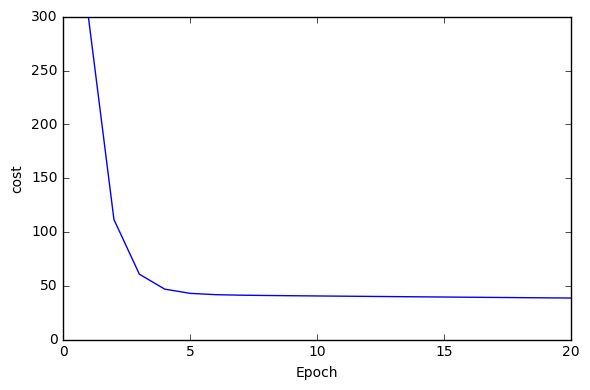

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso


train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

sc_x = StandardScaler()
X_std = sc_x.fit_transform(train_set)
#y_train_std = sc_y.fit_transform(y_train)

llr = LassoRegressor(eta=0.001,alpha=0.001, n_iter=20)
llr = llr.fit(X_std, y_train)


plt.plot(range(1, llr.n_iter+1), llr.cost_)
plt.ylabel('cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('./output/fig-lasso-cost.png', dpi=300)
plt.show()

The figure above shows that our regressor does regress in only just 5 iterations!
So why do I choose small $\eta$ and $\alpha$ ?

Since we want to verify our implementation, we need to make sure it can work properly, that is, it can converge in finite iterations. However, some other factors may also let regressor be unable to converge:
* Overshooting, which happens when the stepsize($\eta$) is too big
* The regressor cannot find a set of $w$ to solve the problem

When we choose a $\alpha$ too big, the coefficients of each features will be pressed to zero, and thus resulting large errors. So, to verify our implementation, we have to rule out these two situations by selecting small $\eta$ and $\alpha$, and thus we can identify the problem of our LassoRegressor more easily.


Now, let's try it with more iterations:

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

llr = LassoRegressor(eta=0.001,alpha=0.001, n_iter=500)
llr = llr.fit(X_std, y_train)

y_train_pred = llr.predict(X_std)

print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(y_train, y_train_pred)))


MSE train: 33.75
R^2 train: 0.61


By examining the $R^2$ and $MSE$, we can see the regressor works fine.

Knowing that our LassoRegressor is usable, we can begin our task 2: **Tune & Train the LassoRegressor**.

# Part II. Tune & Train the LassoRegressor

The purpose of this part is to tune and train our homemade LassoRegressor. Through the process of tuning and training, we can know how each hyper-parameter can affect the behavior and performance of our regressor.

But there are a few things we have to do before we directly jump into the tuning process.

### Inspecting data
Inspecting data can help us:
* Know if our data is learnable
* Know the distribution of each data points/features

Before starting the tuning/training tasks, we should first inspect, we should first ensure that our data is learnable. If the data is just a composition of random noise without any pattern, than it is unlikely to learn anything from it, and the regressor will never converge.

Besides, even if we know that our data can converge(we know it, since we have made it converge in part I), we still need to inspect our data. By inspecting data, we can learn the distribution of data points, and can have a rough idea and direction about what we can try to tune our regressor.

So, inpsecting data is an essential task for all who are trying to solve a problem through machine learning techniques.

In [6]:
import seaborn as sns
import pandas as pd

Now, let us plot the data points of our training set, and check how each feature is related to the label.

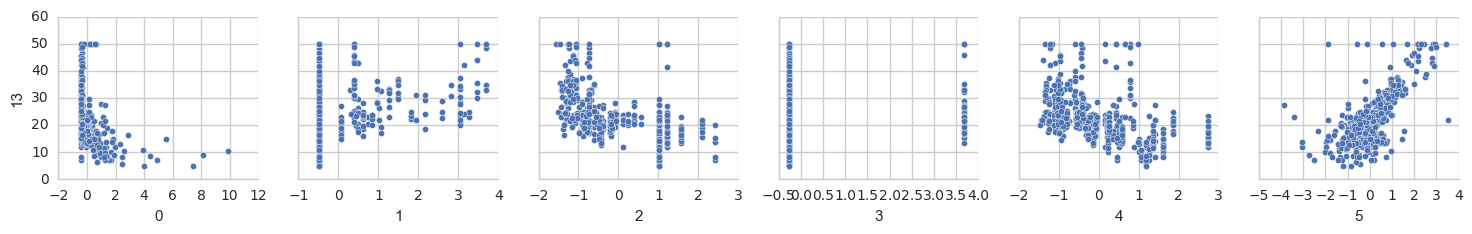

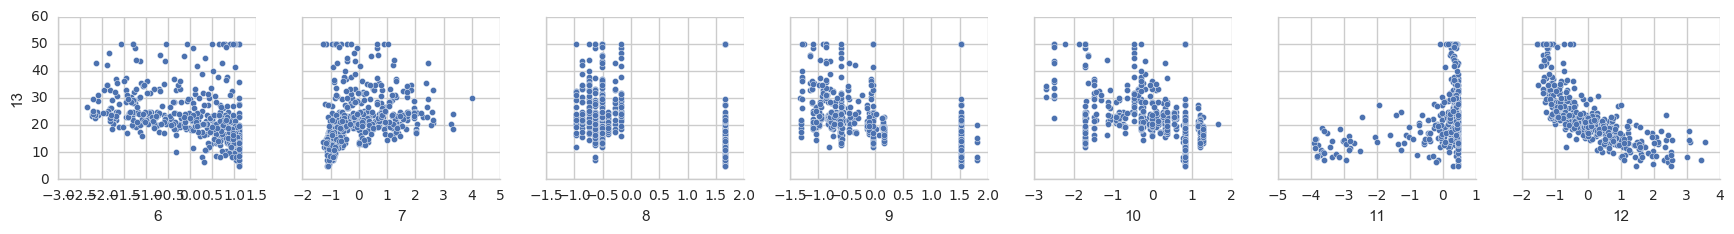

In [7]:
data = np.concatenate([X_std, y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data)
sns.set(style='whitegrid', context='notebook')

# plot it separately for the ease of reading
# notice that '13' the the label.
sns.pairplot(df, x_vars=df.columns[0:int(X_std.shape[1]/2)], y_vars=df.columns[-1], size=2.5)
sns.pairplot(df, x_vars=df.columns[int(X_std.shape[1]/2):X_std.shape[1]], y_vars=df.columns[-1], size=2.5)

plt.tight_layout()
plt.savefig('./output/fig-pairwise-dist.png', dpi=300)
plt.show()
sns.reset_orig()


By observing the figure above, one will notice that some features might be useless, such as feature 3 and 8, since they are not seen to be related to the labels, while features like 5 and 12 have some obvious patterns.

And since most of the features have some patterns that related to our labels, I beleive that it is possible for us to learn things from this data set. Now, let us do some testing to support my assumption.

In [8]:
def mse_lr(model, X, y):
    return ((model.predict(X) - y)**2).mean()

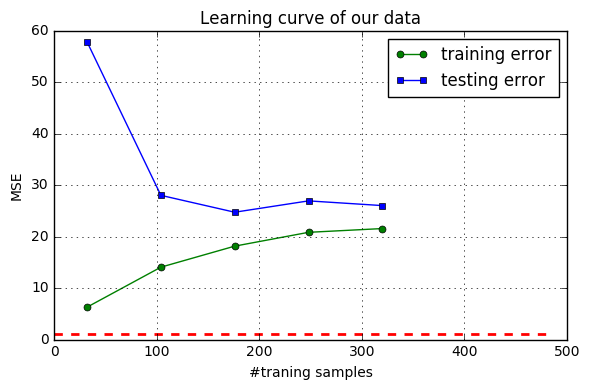

In [9]:
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LinearRegression

test_set = np.loadtxt('X_test.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

num_data = X_std.shape[0]
lr = LinearRegression()

train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X_std, y=y_train, scoring=mse_lr)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='green', marker='o', markersize=5, label='training error')
plt.plot(train_sizes, test_mean, color='blue', marker='s', markersize=5, label='testing error')

plt.hlines(y=1, xmin=0, xmax=num_data, color='red', linewidth=2, linestyle='--')
plt.title('Learning curve of our data')
plt.grid()
plt.xlabel('#traning samples')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig('./output/fig-learning-curve.png', dpi=300)
plt.show()

As the figure above shows, we can surely learn something with this data set. But, one thing we need to know is that if we just use this data to train our linear regressor without processing our data, we might be unable to reach a very low $MSE$, as you can see that the training and testing curve is converged at around 22-24 $MSE$. We will leave this problem to part III.

As for now, we can start tuning, since we've confirmed that the data is learnable.

### Tuning & Training
Our tasks in this section is to :
* tune $\eta$ and $\alpha$
* tune $\eta$ and $\alpha$ to **make $w$ sparse**

First, I will explain how I find $\eta$ and $\alpha$ to get a fine prediction result, and then I will show how I manage to tune an $\alpha$ such that the resulting weights $w$ will be sparse.

Now, let's do the first task. We have two hyper-parameters to tune: $\eta$ and $\alpha$. Before tuning alpha, we should first fine a proper $\eta$, and then find $\alpha$ by using fixed $\eta$.

In [10]:
etas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = 30

for eta in etas:
    print('---- testing eta %.5f ----' % (eta))
    llr = LassoRegressor(eta=eta, n_iter=max_iter)
    llr = llr.fit(X_std, y_train)
    
    print(llr.cost_[-1])

---- testing eta 0.00001 ----
236.312021886
---- testing eta 0.00010 ----
56.5447983811
---- testing eta 0.00100 ----
36.7893688468
---- testing eta 0.01000 ----
Error! Sum of errors exceeds stop criteria
3.98381097927e+25
---- testing eta 0.10000 ----
Error! Sum of errors exceeds stop criteria
1.45385329969e+29


So, as the printed results show, 0.001 might be the best choice for us, since values below it might descent too slow, and values greater than it will cause overshooting, so the sum of errors will eventually exceed stop criteria.

Choosing $\eta=0.001$, we can start seaching for a proper $\alpha$ now. 

running with init alpha : 0.001
running with init alpha : 0.010
running with init alpha : 0.100
running with init alpha : 1.000
Finished searching alpha


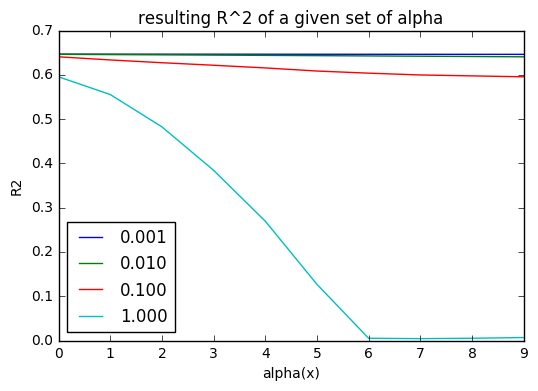

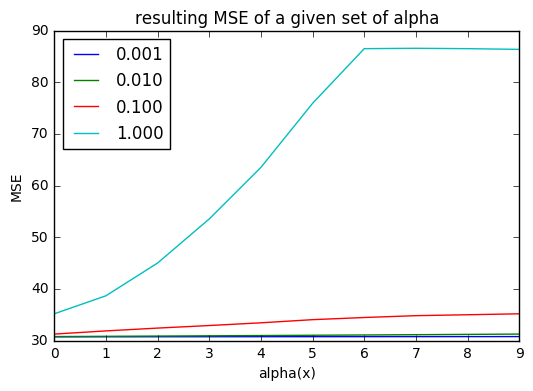

In [11]:
from sklearn.cross_validation import train_test_split

"""    
    We have learned that eta = 0.001 is our best choice,
    now let us find an appropriat alpha value
"""

a = 0.001
eta = 0.001
alphas = [0.001, 0.01, 0.1, 1]
max_iter = 3000

candidates = []
r2_lists = []
mse_lists = []
a_lists = []

for a in alphas:
    print("running with init alpha : %.3f" % (a))

    a_list = []
    r2_list = []
    mse_list = []
    inc = a
    for i in range(0, 10):
        # Examine the result of choosen alpha through training-validating process.
        X_tune_train, X_val, y_tune_train, y_val = train_test_split(
        X_std, y_train, test_size=0.4, random_state=1)

        llr = LassoRegressor(eta=eta, alpha=a, n_iter=max_iter)
        llr = llr.fit(X_tune_train, y_tune_train)
        
        y_val_pred = llr.predict(X_val)
        r2  = r2_score(y_val, y_val_pred)        
        mse = mean_squared_error(y_val, y_val_pred)
        
        a_list.append(a)
        r2_list.append(r2)
        mse_list.append(mse)
    
        a += inc
    # collect testing result
    a_lists.append(a_list)
    r2_lists.append(r2_list)
    mse_lists.append(mse_list)
    
print('Finished searching alpha')



a = 0.001
# now, we plot the resulting R^2 value of a given set of alpha values.
# each line in the figure indicates the resulting value of R^2 from 'a' to 'a * 9'
# (ex. if a = 0.001, then the line of 0.001 will be the R^2 value from 0.001 to 0.009)
for l in r2_lists:
    a_alpha = "%.3f" % a
    plt.plot(range(0,10), l, label=a_alpha)
    a *= 10

plt.title('resulting R^2 of a given set of alpha')
plt.ylabel('R2')
plt.xlabel('alpha(x)')
plt.legend(loc='best')
plt.savefig('./output/fig-alpha-plot-r2', dpi=300)
plt.show()


# same as above, but this time, we plot the MSE value.
a = 0.001
for l in mse_lists:
    a_alpha = "%.3f" % a
    plt.plot(range(0,10), l, label=a_alpha)
    a *= 10
    
plt.title('resulting MSE of a given set of alpha')
plt.ylabel('MSE')
plt.xlabel('alpha(x)')
plt.legend(loc='best')
plt.savefig('./output/fig-alpha-plot-mse', dpi=300)
plt.show()


As the figure shows above, if we want to have a good R^2/MSE results, we might need to pick a small $\alpha$. We will explain this later. Now let's compare our LassoRegressor with sklearn LinearRegressor

In [12]:

X_test = np.loadtxt('X_test.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

X_test = sc_x.transform(X_test)

olr = LinearRegression()
olr = olr.fit(X_std, y_train)

llr = LassoRegressor(alpha=0.001, n_iter=max_iter)
llr = llr.fit(X_std, y_train)

y_train_pred_o = olr.predict(X_std)
y_test_pred_o = olr.predict(X_test)

y_train_pred = llr.predict(X_std)
y_test_pred = llr.predict(X_test)


print("Ordinary least square regressor")
print(" R2 train: %.2f, test: %.2f" %(
        r2_score(y_train, y_train_pred_o), 
        r2_score(y_test, y_test_pred_o))
     )
print("MSE train: %.2f, test: %.2f" %(
        mean_squared_error(y_train, y_train_pred_o), 
        mean_squared_error(y_test, y_test_pred_o))   
    )

print("\nMy LassoRegressor")
print(" R2 train: %.2f, test: %.2f" %(
        r2_score(y_train, y_train_pred), 
        r2_score(y_test, y_test_pred))
     )
print("MSE train: %.2f, test: %.2f" %(
        mean_squared_error(y_train, y_train_pred), 
        mean_squared_error(y_test, y_test_pred))    
    )


Ordinary least square regressor
 R2 train: 0.74, test: 0.73
MSE train: 22.25, test: 15.81

My LassoRegressor
 R2 train: 0.72, test: 0.74
MSE train: 23.68, test: 15.17


It's good to know that our LassoRegressor works very well, and resulting in a little bit higher $R^2$ and $MSE$ result in test set. But the werid thing is: our regressor does not do any better than sklearn in the training phase. 

So why did it can surpass the scikit-Linear regressor(ordinary least square regressor)? One possible reason is that the testing data is too small, and the testing data may just happen to match the pattern our regressor has learned. Once the testing data become bigger and bigger, the scikit one may eventually surpass our regressor.


### Tuning $\alpha$ to make $w$ sparse
Now, we have to tune the $\alpha$ to make $w$ sparse.

In [13]:

def plot_compress(coef, max_alpha, title='LassoRegressor'):
    """ A helper function that help us plot our coefficients(weights)
    
    Parameters
    ----------
    coef : ndarray
           List of coefficients(weights) with respects to some alpha value.
    max_alpha : int
           Maximum alpha value.
    title : str
           The title of resulting figure.
    
    """
    
    plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

    for i in range(coef.shape[1]):
        plt.plot(range(max_alpha),coef[:,i])
    
    plt.title(title)
    plt.ylabel('Coefficients')
    plt.xlabel('Alpha')
    plt.tight_layout()
    plt.savefig('./output/fig-%s-decay.png' % title, dpi=300)
    plt.show()


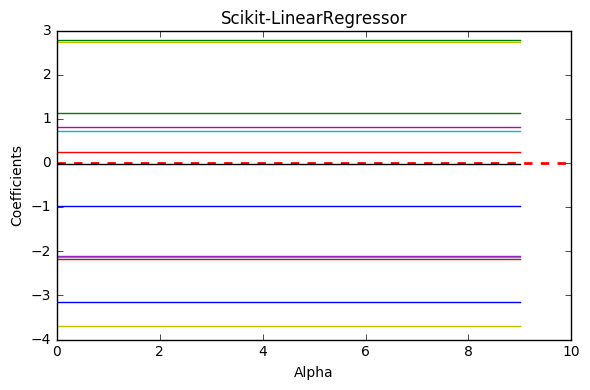

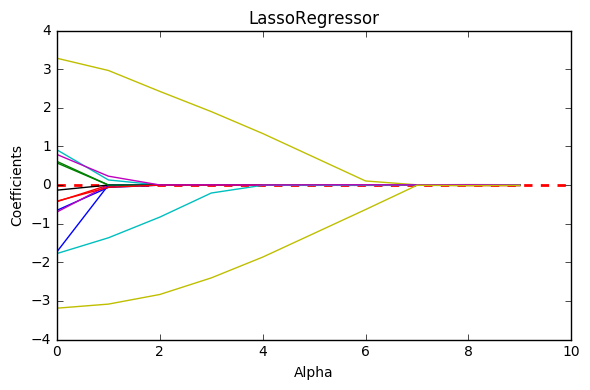

In [14]:
max_alpha = 10

coef_lr  = np.zeros((max_alpha, X_std.shape[1]))
coef_llr = np.zeros((max_alpha, X_std.shape[1]))

for a in range(max_alpha):
    lr = LinearRegression()
    lr.fit(X_std, y_train)
    
    llr = LassoRegressor(alpha=a, n_iter=max_iter)
    llr.fit(X_std, y_train)
    
    coef_lr[a,:] = lr.coef_.reshape(1, -1)
    coef_llr[a,:] = llr.w_[1:].reshape(1, -1)

plot_compress(coef_lr, max_alpha, title='Scikit-LinearRegressor')
plot_compress(coef_llr, max_alpha)

Ordinary least square regressor will just simply compute:
$$min_{w}\Vert Xw - y\Vert_{2}^{2}$$

So it's not surprise to have a flat $w$.

However, the $\alpha$ term will work as a compressor in **LassoRegressor** : The larger the $\alpha$, the smaller the coefficients, and **the less useful a feature is, the faster it will be compressed to zero**. 

And in our LassoRegressor, the $w$ will be become sparse will $\alpha$ is closed to 1, and will have only 3 featues left when $\alpha=2$.

This figure can also explain when $R^2$ and $MSE$ escalated quick when we picking a $\alpha$ larger than 1. When $\alpha$ reaches 1, many of the weights have been pressed to zero, that is, some possibly useful features might be eliminated from the regressor. and when $\alpha$ gets to 6, all the weights have been pressed to zero, which means that the regressor make prediction based on **only on bias, since other features have been totally eliminated**.

So if you check the figure of $MSE$ and $R^2$, you will find that $R^2$ reaches 0.0 and the curve of $MSE$ is flatten after setting $\alpha=6$



### Conclusion

In this section, we have found that:
* $\eta=0.001$ with $\alpha=0.001$ can make our regressor work well
* when $\alpha$ reaches 1, it will start becoming sparse

# Part III. Feature Selecetion and XRegressor

### Quick summary 
* Best $\overline{R}^2$ : $0.77$ (using 10 features), with $R^2$ : $0.86$ and $MSE$ : $7.96$

In this section, we have to apply what we have learned during the past few weeks to make $\overline{R}^2$ score as higher as possible. To complete this task, we have to develop our **XRegressor** to fulfill this task. I will discuss this in the following order:
* Design of XRegressor
* Feature selection
* Removing outlier
* Generating features
* Final result

Now, let us begin!
### Design of XRegressor
My XRegressor is still a lasso regressor. Or, more precisely, it's a lasso based regressor, with **Coordinate Descent** method and a pipepine designed for **data processing**. The core idea of  **Coordinate Descent** is simple:
We perform line search procedure along **one coordinate direction at a time**, instead of computing the gradient of all weights at once. In each iteration, we will minimize the cost along one direction at a time. One benefit of this method is that since we only care about **one weight** at a time, so no partial differentiation needs to be calculated, and thus we don't need to worry about the subgradient problems that we encountered in part I. The update rules of my XRegressor is as follow:
$$w_{j}=\frac{S(\sum^{N}_{i=1}x_{ij}(y_{i}-\tilde{y_{i}}), \alpha)}{\sum_{i=1}^{N}x_{ij}^2}, \text{where}$$
$$S(w,\alpha)=\begin{cases}
sign(w)(|w| - \alpha) & \text{if w - $\alpha$} > 0\\ 
0 & \text{otherwise}
\end{cases}$$

$w_j$ is the $j\text{th}$ weights, $N$ is the number of training samples, $x_{ij}$ is the $j\text{th}$ feature of $i\text{th}$ sample, and $S$ is called  **soft thresholding**.

More details will be given in the comments of **XRegressor** below:

In [15]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class XRegressor(object):
    """
        A lasso regressor that uses coordinate descent as a descent method
    """
    def __init__(self, alpha=0.001, n_iter=40, random_state=1, zero=1e-10):
        """ Initilialize XRegressor.
        
        Parameters
        ----------
        alpha : float
                The coefficient of the 1-norm term in the cost function
        n_iter : int
                Number of iterations.
        random_state : int
                Randome seed.
        zero : float
                Value that smaller than zero will be considered as zero.              
        """
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.zero = zero
        self.random_state = random_state
        self.poly = None
        self.e_f_ = False
        self.r_f_ = False
        self.p_f_ = False
        
    def fit(self, X, y, n_e_iter=3000, n_alpha=2.0, n_feat=5, rf_thresh=4.0, degree=2,
                        extract_feats=False, remove_outlier=False, augment=False, stop_crit=1e+15):
        """ Fitting model, with lots of option that can be used to process data.
        
        Parameters
        ----------
        X : ndarray
            Training data.
        y : ndarray
            Label of data.
        n_e_iter : int
            Number of iterations for Lasso feature selector.
        n_alpha : float
            Alpha value for Lasso feature selector.
        n_feat : int
            Number of selected features that the Lasso feature selector should return.
        rf_thresh : float
            Residual threshold for RANSAC outlier remover.
        degree : int
            Degrees of Polyfeatures.
        extract_feats : boolean
            If XRegressor should extract feature or not. (by using Lasso feature selector)
        remove_outlier : boolean
            If XRegressor should remove outlier or not. (by using RANSAC)
        augment : boolean
            If XRegressor should augment data or not. (by using PolyFeatures)
        stop_crit : float
            If the result of cost function exceeds this value,
            the training process will be stop since it cannot
            converge.
        
        Returns
        -------
        self : XRegressor
               Trained model.
        """
        
        # selecting features using LassoRegressor in partI
        # the pre-defined alpha value is 2, which is based on 
        # our experiments of alpha tuning in part 2.
        if extract_feats:
            self.e_f_ = True
            llr = LassoRegressor(alpha=n_alpha, n_iter=n_e_iter)
            llr = llr.fit(X, y)
            # argsort will return an ascending list,
            # use [::-1] to reverse it to get the first
            # n_feat features.
            feat = np.argsort(np.fabs(llr.w_[1:]))[::-1]
            self.selected = feat[0:n_feat]
        
        if remove_outlier:
            self.r_f_= True
            
        if augment:
            self.p_f_ = True
            self.p_degree = degree
        
        # process data.
        X, y = self.process_data_(X, y, rf_thresh, training=True)
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        N = X.shape[0]
        # compute the term sum(X_ij)**2
        norm_X = (X**2).sum(axis=0)
        
        # same as LassoRegressor, self.w_[0] is still the bias/intercept.
        # in coordinate descent method, we need to perform the descent
        # "one weight at a time", that is why we have 2 for-loop here.
        # (the whole process is similar to the one used in sklearn:enet_coordinate_descent)
        for i in range(self.n_iter):
            for j in range(1, len(self.w_)):
                # predict the result by fixing all value,
                # but remove the term xj_wj from prediction.
                r_resp = self.predict(X, ignore=j)
                
                # compute partial residual, that is, the cost 
                # along the coordinate.
                pr = y - r_resp
                    
                # Trying to minimize the cost along coordinate j.
                # the j-1 term is the weight of featue 0 is at index 1 of w_[],
                # so subtract 1 to get correct index.
                r_pred = X[:, j-1].dot(pr).sum()
                
                # perform thresholding to remove weights that is too low
                self.w_[j] = self.soft_threshold_(r_pred, N) / norm_X[j-1]
            output = self.predict(X)
            errors = y - output

            # compute the cost, same as LassoRegressor.
            L1_norm = np.abs(self.w_[1:]).sum()
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / (2.0 * N) + self.alpha * L1_norm
            self.cost_.append(cost)
            
            
            if errors.sum() >= stop_crit:
                print("Error! Sum of errors exceeds stop criteria")
                break
        
        return self
    
    def soft_threshold_(self, r_pred, N):
        """ Sort threshold to supress coefficient that is to small to zero.
        
        Parameters:
        -----------
        r_pred : ndarray
                 A "predicted" value of new coefficient.
        N : int
                 Number of samples
                     
        Returns
        -------
            updated coefficient.
        """
        if np.fabs(r_pred) < (self.alpha * N):
            return 0
        return np.sign(r_pred) * (np.fabs(r_pred) - (self.alpha * N))

    def process_data_(self, X, y=None, thresh=4.0, training=False):
        """ Pre-process the data to make it meet the format of regressor
        
        Parameters
        ----------
        X : ndarray
            Data to be processed.
        y : ndarray
            Labels of data.
        thresh : float
            Residual threshold for RANSAC outlier remover.
        training : boolean
            In training phase of not.
        
        Returns
        -------
        X : ndarray
            Processed training data.
        y : ndarray
            Processed training labels.
        """
        
        # process data through a pipeline according optional flags.
        if self.e_f_:
            X = self.extract_feats_(X)
        
        # we can only remove outlier in training set.
        # It makes zero sense to remove data from testing set.
        if self.r_f_ and training:
            X, y = self.ransac_feats_(X, y, thresh)
        
        # augment data using PolynomailFeatures.
        # we only need to init one instance for augmenting data
        if self.p_f_:
            if training:
                self.poly = PolynomialFeatures(degree=self.p_degree)
                self.poly.fit(X)

            X = self.data_aug_(X)
        return X, y
    
    def extract_feats_(self, X):
        """ Extraced feature with pre-computed result.
        
        Parameters
        ----------
        X : ndarray
            Data to be extraced.
        
        Returns:
        X : ndarray
            Selected features.
        """
        return X[:, self.selected]
    
    def ransac_feats_(self, X, y, thresh=4.0):
        """ Remove outlier with a given residual threshold.
        
        Parameters
        ----------
        X : ndarray
            Data to be processed.
        y : ndarray
            Labels to be processed.
        thresh : float
            Residual threshold.
        
        Returns:
        X_filt : ndarray
                 Inlier.
        y_filt : ndarray
                 Labels of inlier.
        """
        # use RANSAC to remove outlier.
        ransac = RANSACRegressor(LinearRegression(), 
                max_trials=100, 
                min_samples=50, 
                residual_threshold=thresh, 
                random_state=0)
        ransac = ransac.fit(X, y)
                   
        inlier = ransac.inlier_mask_
        X_filt = X[inlier, :]
        y_filt = y[inlier]
        return X_filt, y_filt
    
    def data_aug_(self, X):
        """ Using pre-fitted PolyFeatures to do data augmentation.
        
        Parameters
        ----------
        X : ndarray
            Data to be augmented.
        
        Returns:
            Augmented data.
        """
        return self.poly.transform(X)
    
    def predict(self, X, ignore=None):
        # for x^0 to x^n 
        """ Predict the result of given input.
        
        Parameters
        ----------
        X : ndarray
            Data to be predicted.
        ignore : int
            The feature that will be ignored during the predicting process.
        
        Returns
        -------
            Result of prediction.
        
        """
        if ignore == None:
            return np.dot(X, self.w_[1:]) + self.w_[0]
        
        ign_ = deepcopy(self.w_[1:])
        ign_[ignore-1] = 0
        
        return np.dot(X, ign_) + self.w_[0]
    

Again, we need to verify our design.

Let's see if it can converge:

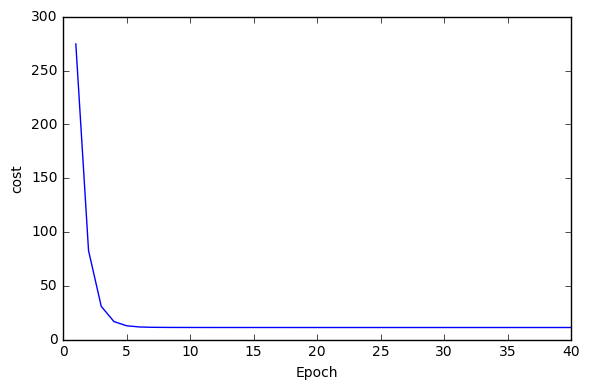

MSE train: 22.25
R^2 train: 0.74


In [16]:
train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

sc_x = StandardScaler()
X_std = sc_x.fit_transform(train_set)

xr = XRegressor()
xr = xr.fit(X_std, y_train, extract_feats=False)

plt.plot(range(1, xr.n_iter+1), xr.cost_)
plt.ylabel('cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('./output/fig-lasso-cd-cost.png', dpi=300)
plt.show()

y_train_pred = xr.predict(X_std)
print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(y_train, y_train_pred)))


The result shows **XRegressor** does converge! And it also converges faster than the **subgradient descent** method! It can reach a very high $R^2$ in just a few iterations, but why? One possible reason is that we will always use "fresh information" to update the weight of one coordinate. For example, after completing updating the weight of $w_j$, $w_{j+1}$ will utilize this new $w_{j}$ to do the descent, and thus leads to a faster convergence rates.

(referecnce: On the Finite Time Convergence of Cyclic Coordinate Descent Methods)

Now, we also need to check if the coordinate descent Lasso can perform the feature selection task:

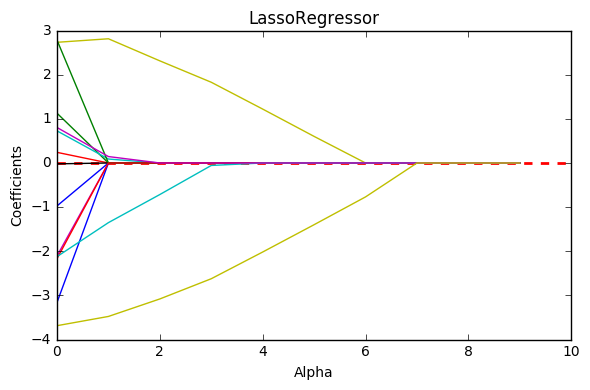

In [17]:
max_alpha = 10
coef = np.zeros((max_alpha, X_std.shape[1]))

for a in range(max_alpha):
    xr = XRegressor(alpha=a, n_iter=max_iter)
    xr.fit(X_std, y_train)
    coef[a,:] = xr.w_[1:].reshape(1, -1)
    
plot_compress(coef, max_alpha)

The **XRegressor** can successfully select features, according to the resulting figure.

Now let's see how much $\overline{R}^2$ we can get from testing set.

In [41]:
def r2_bar_score(y, y_pred, N, P):
    """ Compute adjusted R^2
    
    Parameters
    ----------
    y : ndarray
        Labels.
    y_pred : ndarray
        Predictions.
    N : int
        Number of predictions.
    P : int
        Number of selected features.
    
    Returns
    -------
        adjusted R^2.
    """
    return 1 - ((((y - y_pred)**2).sum()) / (N - P - 1)) / ((((y - np.mean(y))**2).sum()) / (N - 1))


In [42]:
xr = XRegressor(alpha=0.001, n_iter=max_iter)
xr = xr.fit(X_std, y_train)
y_test_pred = xr.predict(X_test)

print("R2_bar_score: %.2f" %(r2_bar_score(y_test, y_test_pred, X_test.shape[0], xr.w_.shape[0]-1)))


R2_bar_score: 0.44


The result is extremely bad! So we have to take some action to improve our performance. 

In the following section, you will see how I deal with all those data, and improve the $\overline{R}^2$.

### Feature selection

Our **LassoRegressor** will act as the feature selector of our **XRegressor**. We choose the same $\alpha$ value, and plot the selected features:

Feature #12 : -2.83365
Feature #5 : 2.42537
Feature #10 : -0.82958
Feature #0 : -0.00296
Feature #4 : -0.00294
Feature #11 : 0.00231
Feature #2 : -0.00223
Feature #8 : -0.00189
Feature #6 : -0.00176
Feature #1 : 0.00136
Feature #9 : -0.00135
Feature #7 : 0.00069
Feature #3 : 0.00045


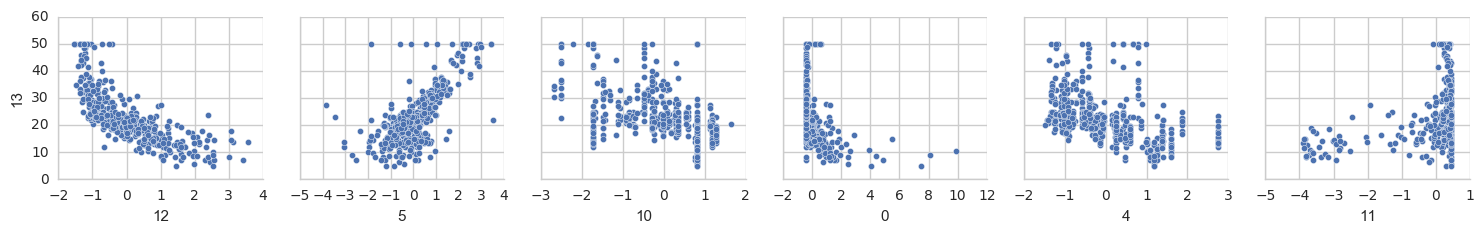

In [18]:
llr = LassoRegressor(alpha=2, n_iter=3000)
llr = llr.fit(X_std, y_train)
feat = np.argsort(np.fabs(llr.w_[1:]))[::-1]

for i in range(len(llr.w_[1:])):
    print("Feature #%d : %.5f" %(feat[i], llr.w_[feat[i]+1]))

n_sel = 6
selected = feat[0:n_sel]
selected_data = np.concatenate([X_std, y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(selected_data)
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[selected], y_vars=df.columns[-1], size=2.5)
plt.tight_layout()
plt.savefig('./output/fig-feat-best.png', dpi=300)
plt.show()
sns.reset_orig()


The reason why we plot out selected features is that:
* we want to know what features is selected
* we can examine if the feature is truly meaningful

As we have mentioned in previous section, it's important for us to know what kind of data we are dealing with, and plotting out these figures do help us to understand our data. Although we can know if a feature is important or not through the process of tuning and traning, sometimes we have to rely on our own judgement, and decide if we truly need these selected features or not.

And the result do meet what we have expected in part II : feature 5 and 12 are both great for prediction, and feature 3 and 8 are useless as expected, since those features are not seen to related to the labels.

You can see there is actually a large gap between $3\text{th}$ and $4\text{th}$ features, so here we can make an assumptions that **we do not really need more than 3 features**, so let's do some simple experiment to verify this:

In [20]:
def print_train_val(y_train_pred, y_train, y_valid_pred, y_valid, train_size, valid_size, P):
    """ Print out training/validating result
    
    Parameters
    ----------
    y_train_pred : ndarray
                   Prediction of training data.
    y_train : ndarray
                   Label of training data.
    y_valid_pred : ndarray
                   Prediction of validation data.
    y_valid : ndarray
                   Label of validation data.
    train_size : int
                   Number of samples of training data.
    valid_size : int
                   Number of samples of validation data.
    P : int
                   Number of selected features.
    """
    print("      Training R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
        r2_bar_score(y_train, y_train_pred, train_size, P),
        r2_score(y_train, y_train_pred),
        mean_squared_error(y_train, y_train_pred)
    ))
    
    print("      Testing(Validating) R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
        r2_bar_score(y_valid, y_valid_pred, valid_size, P),
        r2_score(y_valid, y_valid_pred),
        mean_squared_error(y_valid, y_valid_pred)
    ))


In [21]:
train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')
X_std = sc_x.fit_transform(train_set)

max_feats = 6
mse_best = 100
r2b_best = 0

selected_list = []

for i in range(1, max_feats+1):
    sc_x = StandardScaler()

    X_tune_train, X_valid, y_tune_train, y_valid = train_test_split(
        X_std, y_train, test_size=0.5, random_state=0)
    
    xr = XRegressor(alpha=0.001, n_iter=max_iter)
    xr = xr.fit(X_tune_train, y_tune_train, n_feat=i, extract_feats=True)

    y_train_pred = xr.predict(X_tune_train[:, xr.selected])
    y_valid_pred = xr.predict(X_valid[:, xr.selected])
    print("=== %d features ===" %(i))
    print("Selected : %s" %(xr.selected))
    print_train_val(y_train_pred, y_tune_train, y_valid_pred, y_valid,
                    X_tune_train.shape[0], X_valid.shape[0], xr.w_.shape[0]-1)
    
    selected_list.append(xr.selected)

=== 1 features ===
Selected : [12]
      Training R2_bar: 0.53, R2: 0.53, MSE: 40.79
      Testing(Validating) R2_bar: 0.54, R2: 0.54, MSE: 38.71
=== 2 features ===
Selected : [12  5]
      Training R2_bar: 0.60, R2: 0.60, MSE: 34.70
      Testing(Validating) R2_bar: 0.66, R2: 0.66, MSE: 28.31
=== 3 features ===
Selected : [12  5 10]
      Training R2_bar: 0.63, R2: 0.64, MSE: 31.67
      Testing(Validating) R2_bar: 0.70, R2: 0.71, MSE: 24.62
=== 4 features ===
Selected : [12  5 10  0]
      Training R2_bar: 0.64, R2: 0.65, MSE: 30.87
      Testing(Validating) R2_bar: 0.70, R2: 0.70, MSE: 25.09
=== 5 features ===
Selected : [12  5 10  0 11]
      Training R2_bar: 0.64, R2: 0.65, MSE: 30.47
      Testing(Validating) R2_bar: 0.70, R2: 0.71, MSE: 24.50
=== 6 features ===
Selected : [12  5 10  0 11  4]
      Training R2_bar: 0.64, R2: 0.65, MSE: 30.40
      Testing(Validating) R2_bar: 0.70, R2: 0.71, MSE: 24.73


The results indicates that using lesser than 2 features might not be a smart choice, while using 3 to 6 features may result in similar performance, which match our assumption.

Since there exists only a very small difference between using 3 features and 6 features, it's wise to choose 3 features, since that:
* the model will be simpler
* those 3 are the most significant features

Those 3 features together increase the peformance significantly, while other features contribute only a little, so we can regard these features as major factors of the regression prediction.

Now, let's further inspect these features:

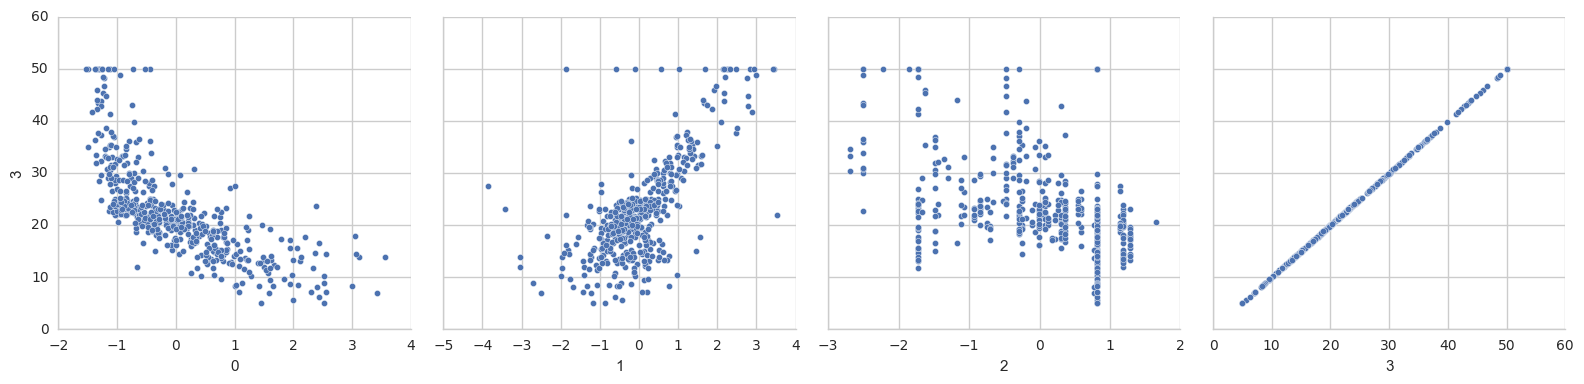

In [22]:

selected = selected_list[2]

data = np.concatenate([X_std[:, selected], y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data)
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[0:X_std[:,selected].shape[0]], y_vars=df.columns[-1], size=4)

plt.tight_layout()
plt.savefig('./output/fig-selected-3feats', dpi=300)
plt.show()
sns.reset_orig()




Closely examine these features, one may find that they do have some pattern. However, one may also notice that there exists many **outliers** that may influence the prediction result, these outlier may possibly drag our regressor away from a good regression line. Thus, removing outlier is a must if we want to improve the accuracy.

### Removing outlier
To remove outlier, we apply **RANSACRegressor** to selected features, mask out those outliers, and use only inliers to train our regressor.

The idea of ransac is simple: we just randomly select some data points, and see if we can use some linear lines to fit those points. For all those points that are within the **residual threshold**, that is, is close enough to the line, will be marked as an inlier, and others will be treated as outliers. This whole process will iterate $T$ times(in my code, I set $T=100$), and the iteration that has the most inliers will be regarded as the **correct answer**, and use the result of that iteration to mask out outliers.

Let's see what we will get after removing outliers:

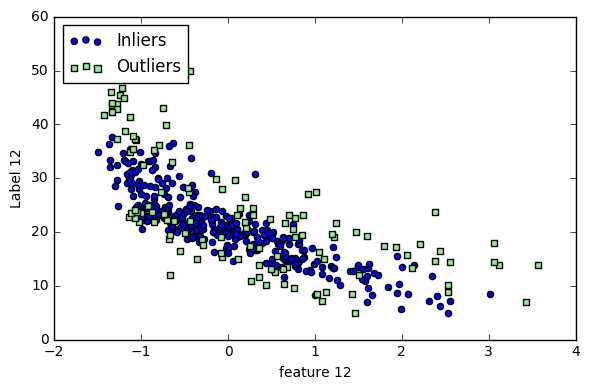

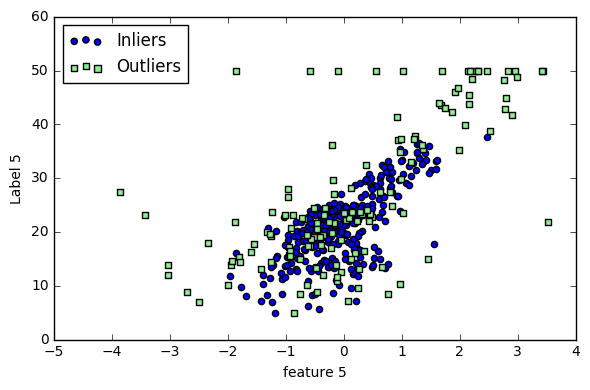

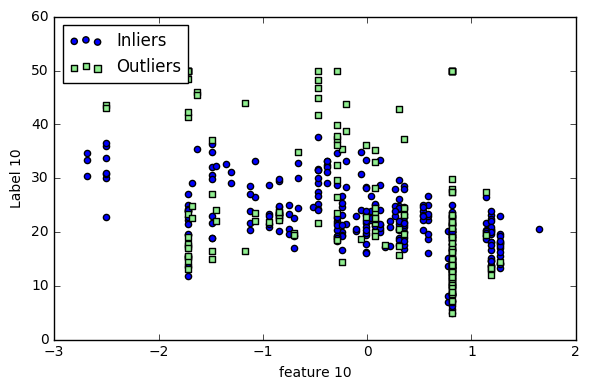

In [23]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

ransac = RANSACRegressor(LinearRegression(), 
            max_trials=100, 
            min_samples=50, 
            residual_threshold=4.0, 
            random_state=0)

ransac.fit(X_std[:, selected], y_train)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
for i in selected:
    X_sel = X_std[:, [i]]
    line_X = np.arange(-4, 5, 1)
    #line_y_ransac = ransac.predict(line_X[:, np.newaxis])
    plt.scatter(X_sel[inlier_mask], y_train[inlier_mask], 
                c='blue', marker='o', label='Inliers')
    plt.scatter(X_sel[outlier_mask], y_train[outlier_mask],
                c='lightgreen', marker='s', label='Outliers')
    #plt.plot(line_X, line_y_ransac, color='red')
    plt.xlabel('feature %d' %(i))
    plt.ylabel('Label %d' %(i))
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()  


Since the whole process is proceed in **3-dimension**, it's hardly for us to know which point will be consider outliers. But as you can see in the figures above, most of the points that seen to related to labels have been selected, so we can expect that the result may be improved, since some annoying outliers are gone.

One thing that worth mentioning is the value of **residual threshold**. This value will largely affect the result of removing outliers. If you set it too high, then nothing will be filtered out; and if it's too low, you will only have few data points that met the RANSAC line, and since number of points is too small, it's unlikely to make our regressor learn a correct pattern.

I choose the value 4.0 as my threshold based on some experiments. The 4.0 works good for RANSAC to keep all the meaningful data, and remove most of the outliers. So let's see if removing outliers really help to improve $R^2$, and see if we can get a nice $\overline{R}^2$ scores.

In [24]:
xr = XRegressor(alpha=0.001, n_iter=max_iter)
xr_nofilt = XRegressor(alpha=0.001, n_iter=max_iter)

xr = xr.fit(X_std, y_train, n_feat=3, rf_thresh=4.0, extract_feats=True, remove_outlier=True)
xr_nofilt = xr_nofilt.fit(X_std, y_train, n_feat=3, extract_feats=True)



y_test_pred = xr.predict(X_test[:, xr.selected])

print("XRegressor(removing outliers) Testing R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
    r2_bar_score(y_test, y_test_pred, X_test.shape[0], xr.w_.shape[0]-1),
    r2_score(y_test, y_test_pred),
    mean_squared_error(y_test, y_test_pred)
    ))

y_test_pred = xr_nofilt.predict(X_test[:, xr_nofilt.selected])

print("XRegressor(without removing outliers) Testing R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
    r2_bar_score(y_test, y_test_pred, X_test.shape[0], xr.w_.shape[0]-1),
    r2_score(y_test, y_test_pred),
    mean_squared_error(y_test, y_test_pred)
    ))

selected = xr.selected
X_filt, y_filt = xr.ransac_feats_(X_std[:, selected], y_train)


XRegressor(removing outliers) Testing R2_bar: 0.75, R2: 0.78, MSE: 13.00
XRegressor(without removing outliers) Testing R2_bar: 0.69, R2: 0.72, MSE: 16.08


The results indicates that by removing outliers, we can achieve a great performance boost! And not only do we have a better $\overline{R}^2$, we also get a good $R^2$. 

After selecting features and removing outliers, now we have a good set of data points for us to traing our regressor. Knowing this data are good, we should futher "exploit" these data points, to see if we can push our performance to the limit!

### Generating features
Our selected features are good, and since it's good, it's reasonable for us to think that their polynomial features are useful. So, we use **PolynomialFeatures**(which we learned from Lab) to generate more new features. But, since we want to have a high $\overline{R}^2$ score, it's important to control the total number of features, since the more features we use, the more penalty we will get, and that is why I just use max degree = 3 in the code below. So let's see if generating new features can help us:

In [35]:

ds = [1, 2, 3]
for d in ds:
    poly = PolynomialFeatures(degree=d)
    X = poly.fit_transform(X_filt)
    
    X_tune_train, X_valid, y_tune_train, y_valid = train_test_split(
        X, y_filt, test_size=0.3, random_state=0)
    
    xr = XRegressor(alpha=0.001, n_iter=max_iter)
    xr = xr.fit(X_tune_train, y_tune_train)
    
    y_train_pred = xr.predict(X_tune_train)
    y_valid_pred = xr.predict(X_valid)

    print(" Train-Val with degree %d (%d features)" %(d, X_tune_train.shape[1]))
    print_train_val(y_train_pred, y_tune_train, y_valid_pred, y_valid,
                    X_tune_train.shape[0], X_valid.shape[0], xr.w_.shape[0]-1)


 Train-Val with degree 1 (4 features)
      Training R2_bar: 0.89, R2: 0.89, MSE: 4.33
      Testing(Validating) R2_bar: 0.87, R2: 0.87, MSE: 4.58
 Train-Val with degree 2 (10 features)
      Training R2_bar: 0.92, R2: 0.92, MSE: 3.34
      Testing(Validating) R2_bar: 0.88, R2: 0.89, MSE: 3.90
 Train-Val with degree 3 (20 features)
      Training R2_bar: 0.92, R2: 0.92, MSE: 3.13
      Testing(Validating) R2_bar: 0.87, R2: 0.90, MSE: 3.72


As you can see, we do get a super huge performance boost, and we even get $R^2$ score that close to $0.9$! And the $MSE$ values are also low, and break the barrier we have mentioned in partII(we can only have 22-24 $MSE$ in training phase). 

It's reasonable to pick degree 2, since that:
* it has the highest $\overline{R}^2$ score, and a good $MSE$
* it doing great in both trainig and validating
* 20 features is too much(we have 13 features originally)

By using 10 features, we have reached a great $\overline{R}^2$, now we can finally see how much we can get from testing set!

### Final result
* iteraions : 3000
* $\alpha$ : 0.001
* number of features : 10 (3 orignal, 7 polynomial)
* residual threshold : 4.0 (for removing outlier)

result : **$\overline{R}^2 : 0.77$,  $R^2 : 0.86$**

In [39]:
xr = XRegressor(alpha=0.001, n_iter=max_iter)
xr.fit(X_std, y_train, n_feat=3, degree=2, rf_thresh=4.0,
       extract_feats=True, remove_outlier=True, augment=True)

X_poly_test, _ = xr.process_data_(X_test)
y_test_pred = xr.predict(X_poly_test)


print("XRegressor (Final result) Testing R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
    r2_bar_score(y_test, y_test_pred, X_poly_test.shape[0], xr.w_.shape[0]-1),
    r2_score(y_test, y_test_pred),
    mean_squared_error(y_test, y_test_pred)
    ))

XRegressor (Final result) Testing R2_bar: 0.77, R2: 0.86, MSE: 7.96


# Conclusion
In this homework, we need to use **everything** that we have learned from previous class and lab. Lots of inspection and observation also take a big part: we need to interpred data, and making our own judgement, since there does not exist a single answer for this assigmemt, **blindly tune the model will not really increase the result**. Both **coding** and **interpreting** data are important when we want to solve machine learning problem!

And it's really exciting to see that we can improve the $\overline{R}^2$ from 0.44 on testing set, to the final result 0.77.